<a href="https://colab.research.google.com/github/lorenzopaolucci/Cygno_Lab_II/blob/master/ferro_analisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installazione di ROOT dal CERN
!mkdir -p APPS
!pwd
!cd APPS && wget --no-check-certificate https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
!cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

base_lib_path = '/content/APPS/root/lib/'
# main paths for ROOT  
import sys
sys.path.append(base_lib_path)
import ctypes
sys.path.append(base_lib_path)
ctypes.cdll.LoadLibrary(base_lib_path+'libCore.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libThread.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libImt.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libRIO.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libNet.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libTree.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libMathCore.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libMatrix.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libHist.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libGraf.so')
# itsllation and root-numpy main PATH
!pip install root-numpy
ctypes.cdll.LoadLibrary(base_lib_path+'libMultiProc.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libGpad.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libGraf3d.so')
ctypes.cdll.LoadLibrary(base_lib_path+'libTreePlayer.so')
# patch to open online FILE
! sudo apt-get install libdavix0v5
ctypes.cdll.LoadLibrary(base_lib_path+'libRDAVIX.so')
! echo "Davix.GSI.CACheck: n" >> $ROOTSYS/etc/system.rootrc
! cp $ROOTSYS/etc/system.rootrc $HOME/.rootrc
! tail -1 $HOME/.rootrc
! pip install -q  python-swiftclient
! pip install -q  keystoneauth1
! pip install -q  h5py

In [ ]:
import sys
import ctypes
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp

! rm cygnus_lib.*; rm mylib.*
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
sys.path.append('.')
! mkdir -p data

import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import time
from sklearn import linear_model, datasets

x_resolution = 2048
y_resolution = 576
cy.set_atlas_style('square')

cimax         = 300
cimin         = 0 
dataSelection = 'LAB'
nsigma        = 2

--2020-07-19 16:56:53--  https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.240.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.240.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35047 (34K) [text/plain]
Saving to: ‘cygnus_lib.py’

cygnus_lib.py       100%[===================>]  34.23K  --.-KB/s    in 0.02s   

2020-07-19 16:56:53 (1.93 MB/s) - ‘cygnus_lib.py’ saved [35047/35047]

--2020-07-19 16:56:53--  https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.240.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.240.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17634 (17K) [text/plain]
Saving to: ‘mylib.py’

mylib.py            100%[===================>]  17.22K  --.-KB/s    in 0.0

In [ ]:
# Ciclo run

t = time.clock()
show_pic = 1
save_file = 0

for nRi in range(3,9):  
    
    # Piedistallo da file 
    
    pdm = pd.read_csv('./ped/mean%d.csv' %nRi)
    pds = pd.read_csv('./ped/sigma%d.csv' %nRi)
    
    m_image = pd.DataFrame.to_numpy(pdm)
    s_image = pd.DataFrame.to_numpy(pds)
    
    th_image = np.round(m_image + nsigma*s_image)
    
    # Apertura file da cloud
    
    try:
        
        if nRi < 10: 
            f  = ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/TES/55Fe_run0%d.root' %nRi)
        
        else:
            f  = ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/TES/55Fe_run%d.root' %nRi)
    
        pic, wfm = cy.root_TH2_name(f)                                              # Prende il nome di ogni immagine nella run
        max_image = len(pic)                                                        # Conta il numero di immagini presenti
        print ("RUN %d, # of Images (TH2) Files: %d " % (nRi,max_image))
        nImag=max_image
    except:
        print ("ERROR: No file %d" % (runI[nRi]))
        break
        
    
    # DBSCAN
    
    for eps in np.arange(0.13,0.131,0.005):
        
        for min_samples in range(38,39,5):
            
            t0= time.clock()
            
            print('Eps %.3f Min Samples %d' %(eps,min_samples))
            
            data_to_save = []
            files = ("./data/dbscan_run%d_sigma%.1f_eps%.3f_mins%d.txt" %           # Prepara il file da salvare
                             (nRi,nsigma,eps,min_samples))                           
        
            for iTr in range(0,nImag):                                              # Ciclo immagini
                
                points_list = []
                
                image = rtnp.hist2array(f.Get(pic[iTr])).T                          # Root hist to numpy array
                
                real_im = image - m_image
                real_th = th_image - m_image
                
                for i in np.arange(0,2048,1):                                       # Crea la lista dei punti sopra soglia 
                    for j in  np.arange(0,576,1):
                        if real_im[i,j] > real_th[i,j] and real_im[i,j] < cimax :
                            points_list.append([i,j,real_im[i][j]])
                
                points = np.array(points_list)
                
                
                scaler = StandardScaler()
                scaler.fit(points)
                param = scaler.get_params
                points_scaled = scaler.transform(points)
        
                dbscan = DBSCAN(eps,min_samples).fit(points_scaled)                         
        
                unique_labels = set(dbscan.labels_)
                colors = [plt.cm.Spectral(each)
                           for each in np.linspace(0, 1, len(unique_labels))]
               
                for ic,col in zip(unique_labels,colors):                            # Ciclo cluster
                    yc = points[:,1][dbscan.labels_==ic]      
                    xc = points[:,0][dbscan.labels_==ic]
                    zc = points[:,2][dbscan.labels_==ic]
                    
                    ph = np.sum(zc)
                    
                    if ic != -1 and show_pic != 0:
                        plt.plot(xc[:], yc[:], '.',markerfacecolor=tuple(col),
                            markeredgecolor=tuple(col), markersize=4)
                       
                    if ic != -1 and len(unique_labels) > 2 and save_file !=0:
                    
                        data_to_save.append([nRi, iTr, ic, ph])
                
                if show_pic !=0:
                    plt.imshow(real_im.T,vmin=0,vmax=10,cmap='Greys')
                    fig = plt.gcf()
                    fig.set_size_inches(20, 10)
                    plt.show()
                    
                    plt.imshow(real_im.T,vmin=0,vmax=10,cmap='Greys')
                    fig = plt.gcf()
                    fig.set_size_inches(20, 10)
                    plt.show()
                
            if save_file !=0 :   
                np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
                print ("out file", files)
                
            print('Time elapsed',time.clock()-t0)
    
t2 = time.clock() - t
print('Total running time %lf' %t2)

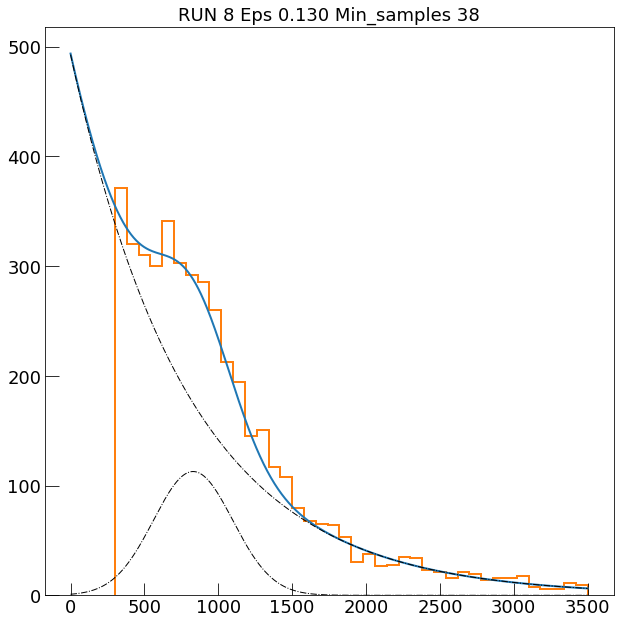

Exponential a*exp(-b*x), a = 492.8 b = 0.001247
Gaussian N = 112.8 mean = 829.4 sigma = 268.2 Area = 75852.683160


In [ ]:
from scipy.optimize import curve_fit

def phot(x,a,b,c,d,e):
            
    return a*np.exp(-b*x) + e*np.exp(-0.5*((x-c)/d)**2)
    
for eps in np.arange(0.13,0.131,0.005):
        
    for min_samples in np.arange(38,39,5):
        
        histogram_phot = np.zeros((1,2))
        
        for nRi in range(3,9):  
            
            data = pd.read_csv('./data/dbscan_run%d_sigma%.1f_eps%.3f_mins%d.txt' %(nRi,nsigma,eps,min_samples),sep=" ",names=[0,1,2,3,4])
            
            temp = data[[1,3]].to_numpy()
            
            histogram_phot = np.vstack((histogram_phot,temp))
        
        if len(histogram_phot) != 0:
                
            yphot,xphot = np.histogram(histogram_phot[:,1],bins=40,range=(300,3500))
            xphot = np.delete(xphot,-1)
            x = np.linspace(0,3500,1000)
            
            par, cov = curve_fit(phot,xphot,yphot,p0=[600,0.001,800,200,1],bounds=(0,1000))
            
            plt.plot(x,phot(x,par[0],par[1],par[2],par[3],par[4]),linewidth=2)
            plt.plot(x,par[0]*np.exp(-par[1]*x),'-.k')
            plt.plot(x,par[4]*np.exp(-0.5*((x-par[2])/par[3])**2),'-.k')
            plt.hist(histogram_phot[:,1],bins=40,range=(300,3500),histtype='step',linewidth=2)
            plt.title('RUN %d Eps %.3f Min_samples %d' %(nRi,eps,min_samples))
            fig=plt.gcf()
            fig.set_size_inches(10, 10)
            plt.show()
            
            print('Exponential a*exp(-b*x), a = %.1f b = %f' %(par[0],par[1]))
            print('Gaussian N = %.1f mean = %.1f sigma = %.1f Area = %f' %(par[4],par[2],par[3],np.sqrt(2*np.pi)*par[4]*par[3]))